In [ ]:
%matplotlib inline
from pathlib import Path

In [13]:
import nibabel as nib 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook


In [21]:
root = Path('../data/Task02_Heart/imagesTr')
label_path = Path('../data/Task02_Heart/labelsTr')

In [22]:
save_root = Path("../data/processed")

In [9]:
train_img_dir = save_root / "train" / "images"
train_mask_dir = save_root / "train" / "masks"
val_img_dir = save_root / "val" / "images"
val_mask_dir = save_root / "val" / "masks"

for dir_path in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)  # ← This creates the folders!

In [ ]:
def inspect_sample_data():
    """Inspect one sample to understand the data"""
    sample_files = list(root.glob("*.nii.gz"))
    if not sample_files:
        print("No .nii.gz files found!")
        return
    sample_image_path = sample_files[0]
    sample_label_path = label_path/ sample_image_path.name

    print(f"Inspecting: {sample_image_path.name}")

    #load data
    mri_data = nib.load(sample_image_path).get_fdata()
    mask_data = nib.load(sample_label_path).get_fdata().astype(np.uint8)

    print(f"MRI shape: {mri_data.shape}")
    print(f"Mask shape: {mask_data.shape}")
    print(f"MRI value range: {mri_data.min():.2f} to {mri_data.max():.2f}")
    print(f"Mask unique values: {np.unique(mask_data)}")

    # Check how many slices have actual masks
    slices_with_mask = 0
    for i in range(mask_data.shape[2]):
        if mask_data[:,:,i].sum() > 0:
            slices_with_mask += 1
    
    print(f"Slices with left atrium: {slices_with_mask}/{mask_data.shape[2]}")

    slice_idx = mri_data.shape[2] // 2
    print(f"Showing slice {slice_idx}")

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # MRI only
    axes[0].imshow(mri_data[:,:,slice_idx], cmap='bone')
    axes[0].set_title('MRI Slice')
    axes[0].axis('off')
    
    # Mask only
    axes[1].imshow(mask_data[:,:,slice_idx], cmap='autumn')
    axes[1].set_title('Left Atrium Mask')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(mri_data[:,:,slice_idx], cmap='bone')
    mask_overlay = np.ma.masked_where(mask_data[:,:,slice_idx]==0, mask_data[:,:,slice_idx])
    axes[2].imshow(mask_overlay, alpha=0.5, cmap='autumn')
    axes[2].set_title('MRI + Mask Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    

inspect_sample_data()

Inspecting: la_007.nii.gz
MRI shape: (320, 320, 130)
Mask shape: (320, 320, 130)
MRI value range: 0.00 to 1873.00
Mask unique values: [0 1]
Slices with left atrium: 76/130
Showing slice 65


<IPython.core.display.Javascript object>

Inspecting: la_007.nii.gz
MRI shape: (320, 320, 130)
Mask shape: (320, 320, 130)
MRI value range: 0.00 to 1873.00
Mask unique values: [0 1]
Slices with left atrium: 76/130
Showing slice 70


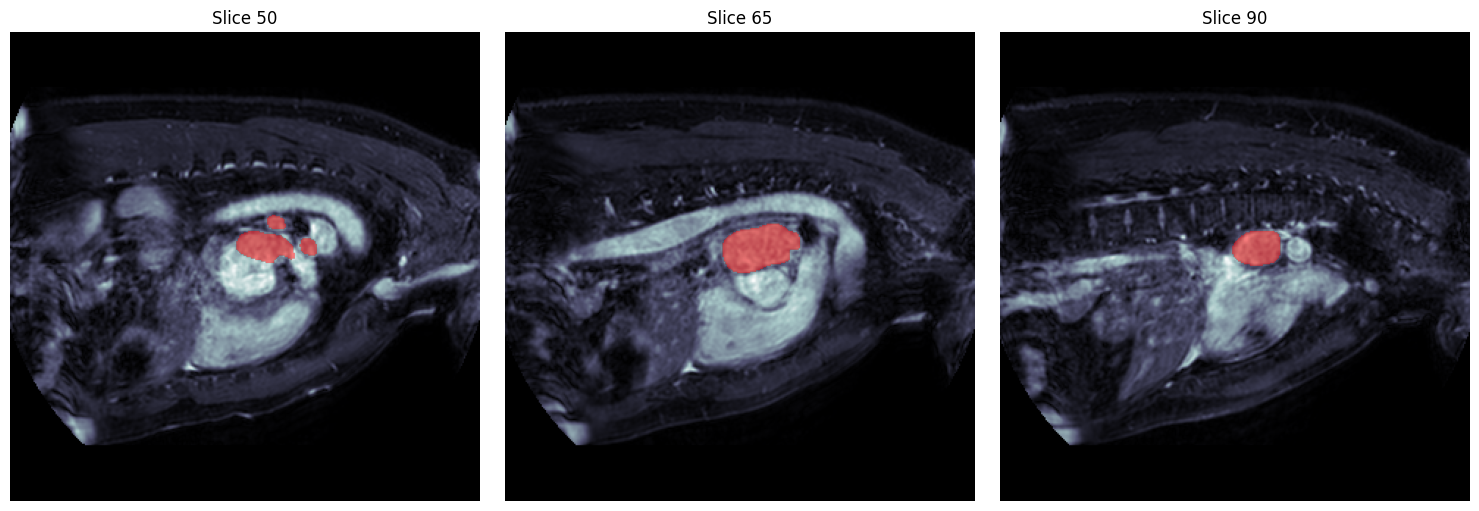

In [ ]:
%matplotlib inline
sample_files = list(root.glob("*.nii.gz"))
    
sample_image_path = sample_files[0]
sample_label_path = label_path/ sample_image_path.name

print(f"Inspecting: {sample_image_path.name}")

#load data
mri_data = nib.load(sample_image_path).get_fdata()
mask_data = nib.load(sample_label_path).get_fdata().astype(np.uint8)

print(f"MRI shape: {mri_data.shape}")
print(f"Mask shape: {mask_data.shape}")
print(f"MRI value range: {mri_data.min():.2f} to {mri_data.max():.2f}")
print(f"Mask unique values: {np.unique(mask_data)}")

# Check how many slices have actual masks
slices_with_mask = 0
for i in range(mask_data.shape[2]):
    if mask_data[:,:,i].sum() > 0:
        slices_with_mask += 1

print(f"Slices with left atrium: {slices_with_mask}/{mask_data.shape[2]}")

slice_indices = [50, 65, 90]
print(f"Showing slice {slice_idx}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, slice_idx in enumerate(slice_indices):
    # Show MRI
    axes[i].imshow(mri_data[:,:,slice_idx], cmap='bone')
    
    # Overlay mask
    mask_overlay = np.ma.masked_where(mask_data[:,:,slice_idx]==0, mask_data[:,:,slice_idx]) #NumPy Masked Arrays
    axes[i].imshow(mask_overlay, alpha=0.5, cmap='autumn') # This shows ONLY the left atrium (1s), zeros are transparent
    
    axes[i].set_title(f'Slice {slice_idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [18]:
def normalize(volume):
    """Z-normalization (mean=0, std=1)"""
    mu = volume.mean()
    std = np.std(volume)
    if std == 0:  # Handle edge case
        return volume - mu
    return (volume - mu) / std

In [19]:
def standardize(normalized_volume):
    """Scale to 0-1 range"""
    min_val = normalized_volume.min()
    max_val = normalized_volume.max()
    if max_val == min_val:  # Handle edge case
        return np.zeros_like(normalized_volume)
    return (normalized_volume - min_val) / (max_val - min_val)

In [20]:
all_files = list(root.glob("*.nii.gz"))
print(f"Found {len(all_files)} files to process")

Found 20 files to process
